In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import tensorflow as tf

from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout,Input,GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# 讀取訓練和測試數據
df = pd.read_csv('train.csv')

In [3]:
#刪掉id,alley、MiscFeature、PoolQC和Fence
df= df.drop(['Id','Alley', 'MiscFeature', 'PoolQC', 'Fence'], axis=1)

In [4]:
y = df['SalePrice']
x = df.drop(columns=['SalePrice'])

In [5]:
# 處理缺失值（數值的na補平均 ; 類別的na補眾數）
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
numerical_cols = numerical_cols[numerical_cols != "SalePrice"]
categorical_cols = df.select_dtypes(include=["object"]).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

In [6]:
# 類別欄位轉數值
LE = LabelEncoder()
for column in categorical_cols:
    df[column] = LE.fit_transform(df[column])
df.head(10)

# 數值欄位標準化
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

## PCA降維

In [8]:
# pca降維
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df.drop("SalePrice", axis=1))

In [9]:
# 查看降維後的數據
print(f"原始數據形狀: {x.shape}")
print(f"PCA 後數據形狀: {X_pca.shape}")

# 查看每個主成分的解釋變異比例
print("每個主成分的解釋變異比例:")
print(pca.explained_variance_ratio_)
print(f"累積解釋變異比例: {np.sum(pca.explained_variance_ratio_):.2f}")

原始數據形狀: (1460, 75)
PCA 後數據形狀: (1460, 42)
每個主成分的解釋變異比例:
[0.28330641 0.16665987 0.07453    0.04098824 0.03431676 0.03050823
 0.02104534 0.02049545 0.01957321 0.01584559 0.01432165 0.0131405
 0.01303506 0.01248626 0.01139335 0.01032962 0.00980754 0.00920818
 0.00885134 0.0083487  0.00809703 0.00793931 0.007767   0.00772502
 0.00762984 0.00750644 0.00710489 0.00685891 0.00670296 0.00645235
 0.00622118 0.00601259 0.0057904  0.00543862 0.00516516 0.00499
 0.00476705 0.00450207 0.00417365 0.00408934 0.00386611 0.00382464]
累積解釋變異比例: 0.95


In [10]:
df[numerical_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.365633,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.574410,-0.973018,-0.288653,...,-0.060731,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439
1456,-0.872563,0.679039,0.266407,-0.071836,0.381743,0.222975,0.151865,0.084843,0.759659,0.722112,...,0.126420,2.033231,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,1.645210
1457,0.309859,-0.183951,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.574410,-0.369871,-0.288653,...,-1.033914,-0.752176,0.201405,-0.359325,-0.116339,-0.270208,-0.068692,4.953112,-0.489110,1.645210
1458,-0.872563,-0.093110,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.574410,-0.865548,6.092188,...,-1.090059,2.168910,-0.704483,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210


In [11]:
# 80%訓練 20%測試
X_train, X_test, y_train, y_test = train_test_split(X_pca,y, test_size=0.2, random_state=42)

#### RandomForest

In [13]:
#RandomForest
model = RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 20282.207282757674


In [14]:
# 計算 MAE
print(f"MAE: {mae}")
# 顯示房價的範圍
print(f"房價範圍：最小值 = {y_test.min()}, 最大值 = {y_test.max()}")

MAE: 20282.207282757674
房價範圍：最小值 = 35311, 最大值 = 755000


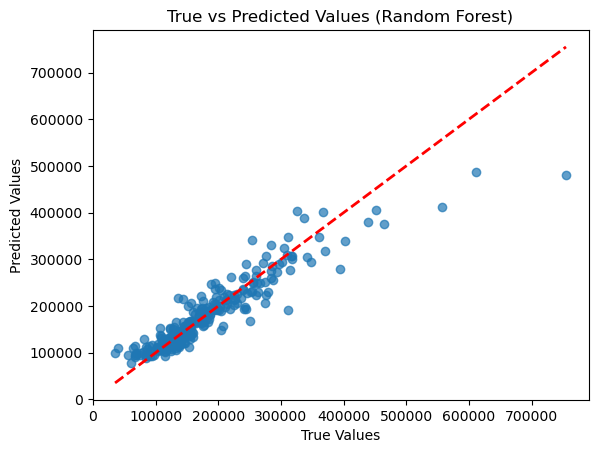

In [15]:
# 繪製預測值與真實值的散點圖
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Random Forest)")
plt.show()

#### CNN

In [17]:
# 建立CNN模型
def build_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

In [18]:
#CNN分析
model_cnn = build_cnn(input_shape=(X_train.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model_cnn.fit(X_train, y_train, epochs=25, batch_size=8, validation_split=0.2, verbose=1, callbacks=[early_stopping])
y_pred_cnn = model_cnn.predict(X_test)

mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
print(f"MAE(cnn): {mae_cnn}")

Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 176579.1406 - mae: 176579.4531 - val_loss: 160744.0781 - val_mae: 160744.0156
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 61266.5000 - mae: 61266.3438 - val_loss: 96197.3906 - val_mae: 96197.1406
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 54561.7656 - mae: 54561.5195 - val_loss: 68377.6797 - val_mae: 68377.4141
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 50550.7109 - mae: 50550.4453 - val_loss: 46980.4023 - val_mae: 46980.1211
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 47891.2422 - mae: 47890.9570 - val_loss: 43932.6016 - val_mae: 43932.3008
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 44454.4727 - mae: 44454.1914 - val_loss: 40087.5078 - val_mae: 40087.2188
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 45906.6992 - mae: 45906.4141 - val_loss: 37690.8789 - val_mae: 37690.5781
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - los

In [19]:
# 評估模型
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
print(f"MAE(CNN): {mae_cnn}")

MAE(CNN): 21665.12508026541


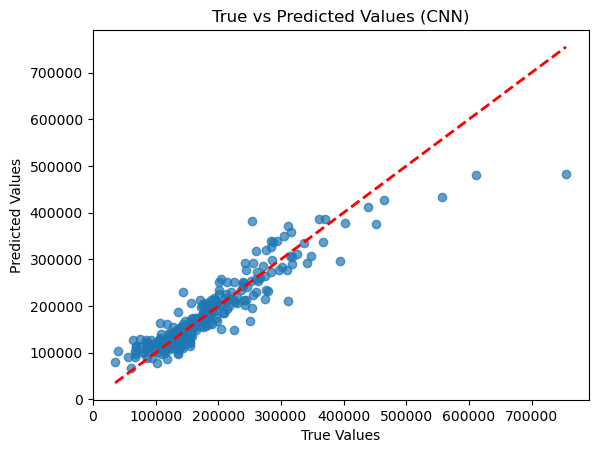

In [20]:
# 繪製預測值與真實值的散點圖
plt.scatter(y_test, y_pred_cnn, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (CNN)")
plt.show()

#### LSTM

In [22]:
# 建立LSTM模型

def build_lstm(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(128, activation='tanh', return_sequences=True,
                  kernel_regularizer=l2(0.001),
                  recurrent_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='mse', metrics=['mae'])
    return model


In [23]:
# LSTM分析
model_lstm = build_lstm(input_shape=(X_train.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model_lstm.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, verbose=1, 
               callbacks=[early_stopping])

y_pred_lstm = model_lstm.predict(X_test)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f"MAE (LSTM): {mae_lstm}")

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 39730532352.0000 - mae: 183261.9531 - val_loss: 35848572928.0000 - val_mae: 175511.8594
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 32845101056.0000 - mae: 161563.3750 - val_loss: 8975098880.0000 - val_mae: 67476.9141
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 9144709120.0000 - mae: 63021.2266 - val_loss: 5060733952.0000 - val_mae: 52470.0469
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 7155054592.0000 - mae: 61059.9727 - val_loss: 5109990400.0000 - val_mae: 51733.8555
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 6178138624.0000 - mae: 54940.2070 - val_loss: 5048266752.0000 - val_mae: 53924.0938
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 6080121856.0000 - mae: 57606.7539 - val_loss: 5064634368.0000 - val_mae: 52372.8594
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 7187593728.0000 - mae: 59168.6133 - val_loss: 5065461248.0000 

In [24]:
# 計算 MAE
print(f"MAE(LSTM): {mae_lstm}")

MAE(LSTM): 24047.501979880137


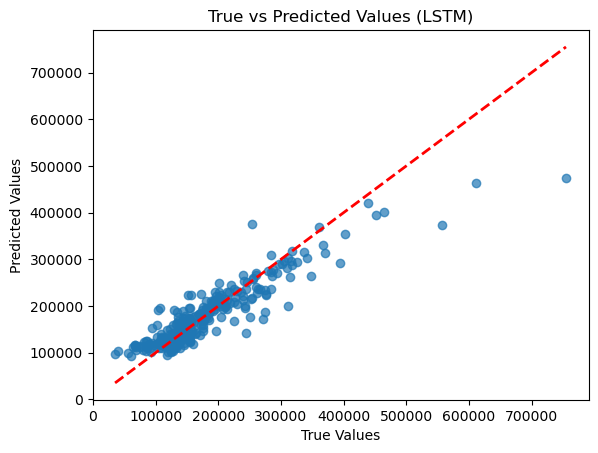

In [25]:
# 繪製預測值與真實值的散點圖
plt.scatter(y_test, y_pred_lstm, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (LSTM)")
plt.show()

#### XGBoost

In [27]:
xgboostModel = XGBRegressor(max_depth = 5, min_child_weight = 4, learning_rate = 0.15)
xgboostModel.fit(X_train, y_train)
y_pred = xgboostModel.predict(X_test)

print("MAE =", mean_absolute_error(y_test, y_pred))

MAE = 18944.179299550513


Text(0.5, 1.0, 'True vs Predicted Values (XGBoost)')

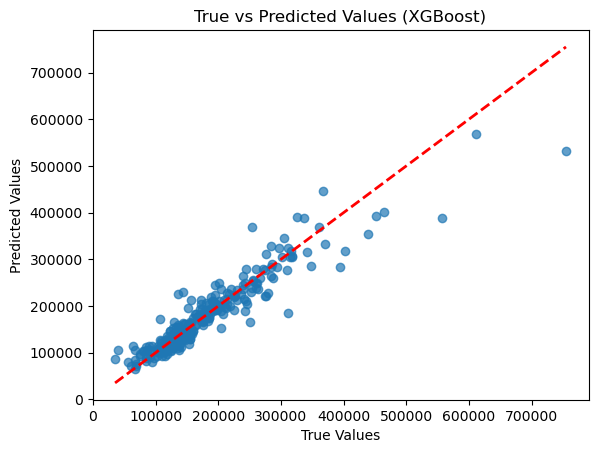

In [28]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (XGBoost)")

#### Linear Regression

In [30]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("MAE =", mean_absolute_error(y_test, y_pred))

MAE = 21044.343765817335


Text(0.5, 1.0, 'True vs Predicted Values (Linear Regression)')

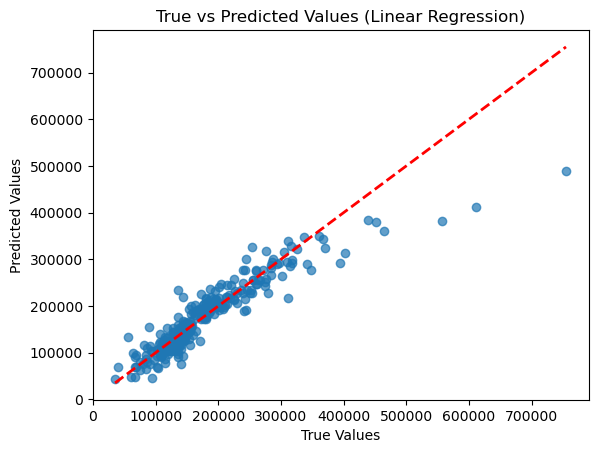

In [31]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Linear Regression)")

#### AdaBoost

In [33]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Absolute Error (MAE): 20819.24


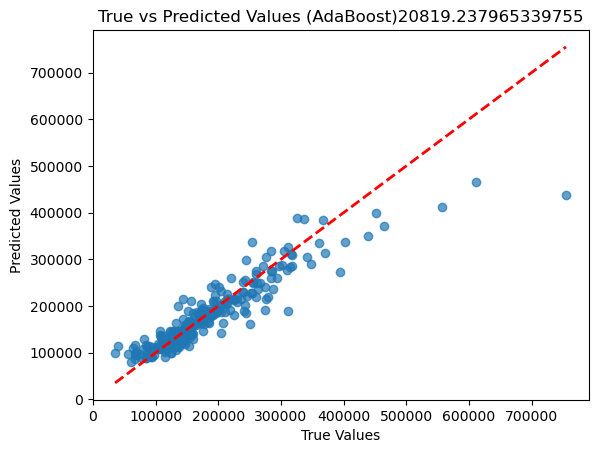

In [34]:
# 設置模型
max_depth = 10
n_estimators=500
#learning_rate = 0.0001
learning_rate=[0.1,0.01,0.001,0.0001,0.00001]
for i in learning_rate:
  #變數
    learning_rate=i
    base_model = DecisionTreeRegressor(max_depth=max_depth)
    adaboost_reg = AdaBoostRegressor(estimator=base_model, n_estimators=n_estimators, random_state=42 ,learning_rate=learning_rate)
    #adaboost_reg = AdaBoostRegressor(random_state=42,n_estimators=n_estimators,learning_rate=learning_rate)
    adaboost_reg.fit(X_train,y_train)
# 預測
y_pred_ada = adaboost_reg.predict(X_test)

# 使用 MAE 評估模型
mae_ada = mean_absolute_error(y_test, y_pred_ada)
print(f"Mean Absolute Error (MAE): {mae_ada:.2f}")
# 繪製預測值與真實值的散點圖
plt.scatter(y_test, y_pred_ada, alpha=0.7)
plt.plot([y_test.min(), y_test_15.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs Predicted Values (AdaBoost){mae_ada}")
plt.show()

## 擷取15個特徵

#### XGboost

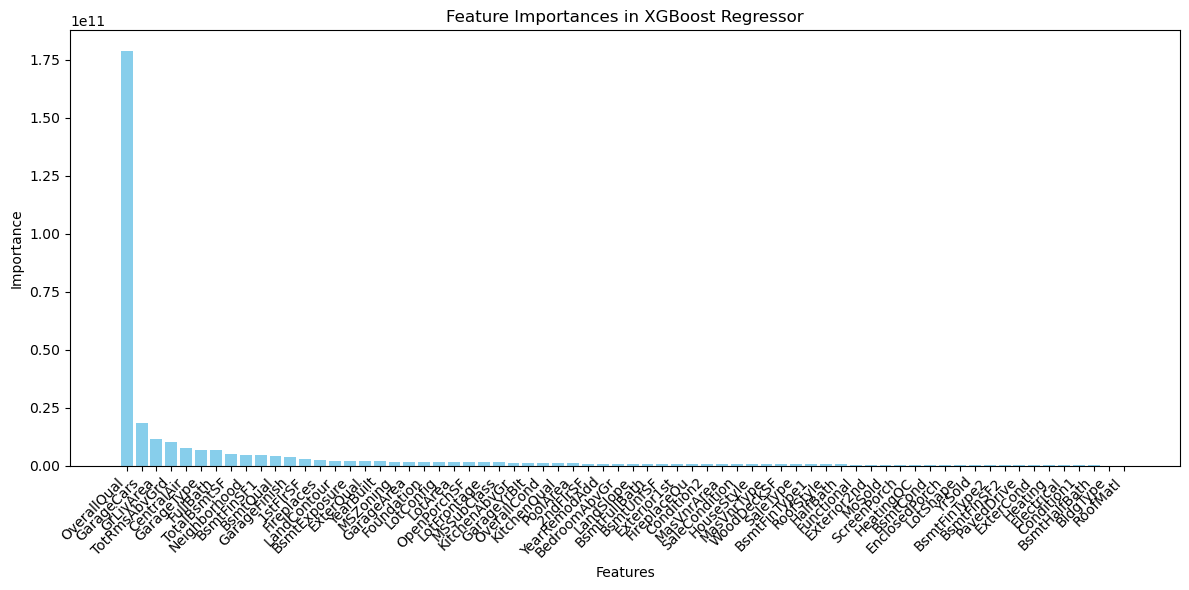

In [37]:
# 排出特徵重要性排行
xgboostModel = XGBRegressor(max_depth = 9, min_child_weight = 6, learning_rate = 0.06)
xgboostModel.fit(X_train_15, y_train_15)

xgboostModel = XGBRegressor(max_depth = 9, min_child_weight = 6, learning_rate = 0.06)
xgboostModel.fit(X_train_15, y_train_15)

importance = xgboostModel.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_df)), importance_df['Importance'], tick_label=importance_df['Feature'], color="skyblue")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances in XGBoost Regressor")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [38]:
xgboostModel = XGBRegressor(max_depth = 3, min_child_weight = 2, learning_rate = 0.25)
xgboostModel.fit(X_train_15, y_train_15)
y_pred_xgboost = xgboostModel.predict(X_test_15)

print("MAE =", mean_absolute_error(y_test_15, y_pred_xgboost))

MAE = 17536.466074486303


Text(0.5, 1.0, 'True vs Predicted Values (XGBoost)')

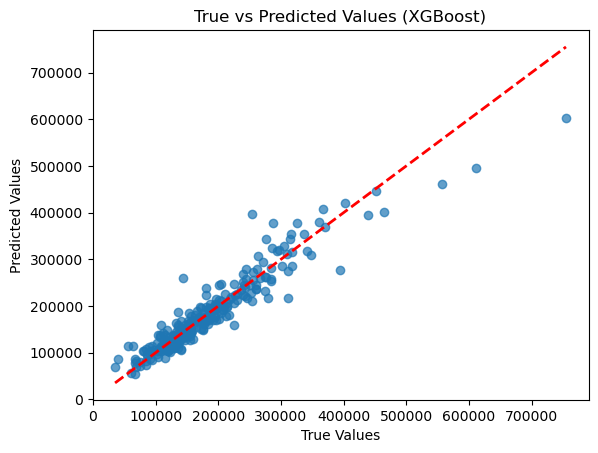

In [39]:
plt.scatter(y_test_15, y_pred_xgboost, alpha=0.7)
plt.plot([y_test_15.min(), y_test_15.max()], [y_test_15.min(), y_test_15.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (XGBoost)")

#### Linear Regression

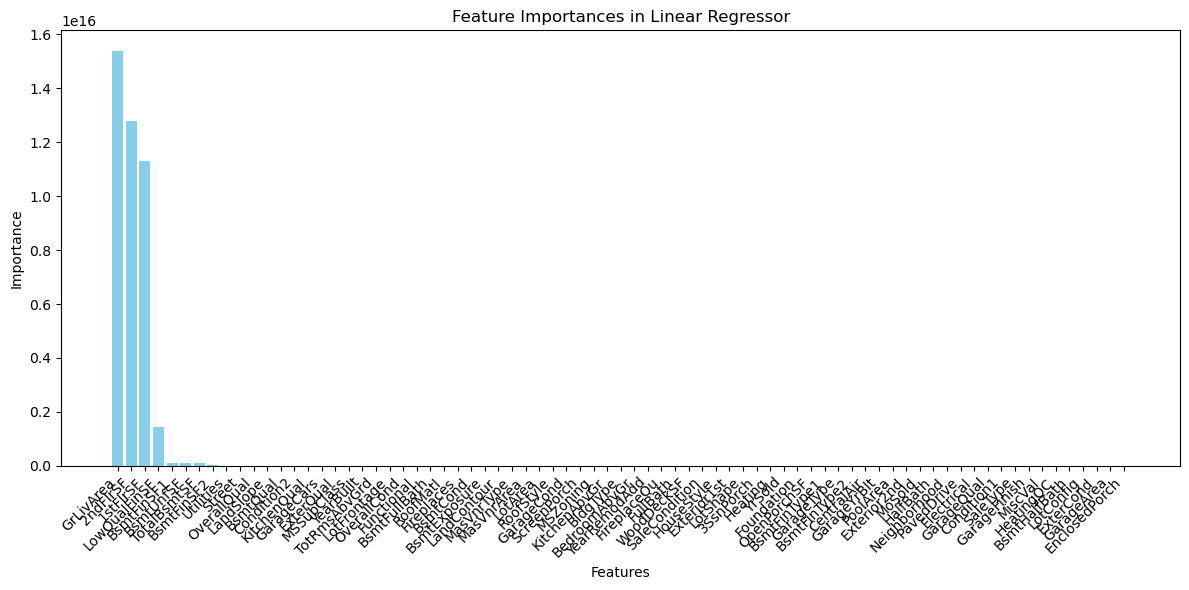

In [41]:
model = LinearRegression()
model.fit(X_train_15,y_train_15)

importance = model.coef_
importance = pd.Series(np.abs(model.coef_), index=X_train_15.columns)

importance_df = pd.DataFrame({
    'Feature': importance.index,
    'Importance': importance.values
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_df)), importance_df['Importance'], tick_label=importance_df['Feature'], color="skyblue")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances in Linear Regressor")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [42]:
model = LinearRegression()
model.fit(X_train_15,y_train_15)
y_pred_lr = model.predict(X_test_15)

print("MAE =", mean_absolute_error(y_test_15, y_pred_lr))

MAE = 21466.28505613644


Text(0.5, 1.0, 'True vs Predicted Values (Linear Regression)')

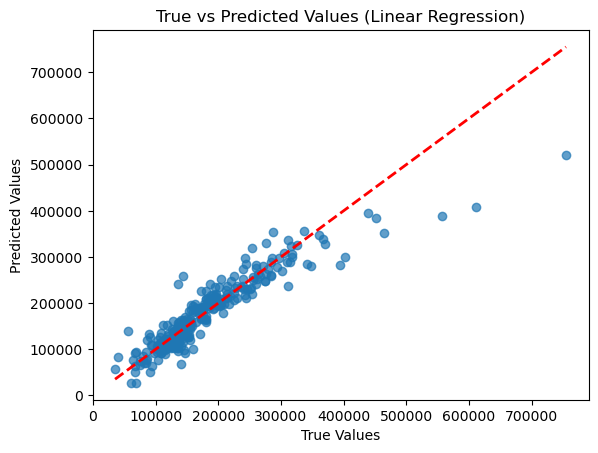

In [43]:
plt.scatter(y_test_15, y_pred_lr, alpha=0.7)
plt.plot([y_test_15.min(), y_test_15.max()], [y_test_15.min(), y_test_15.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Linear Regression)")

#### Random Forest

In [45]:
#建立模型
model = RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=2)
model.fit(X_train_15, y_train_15)

RandomForestRegressor(min_samples_leaf=2, n_estimators=200, random_state=42)

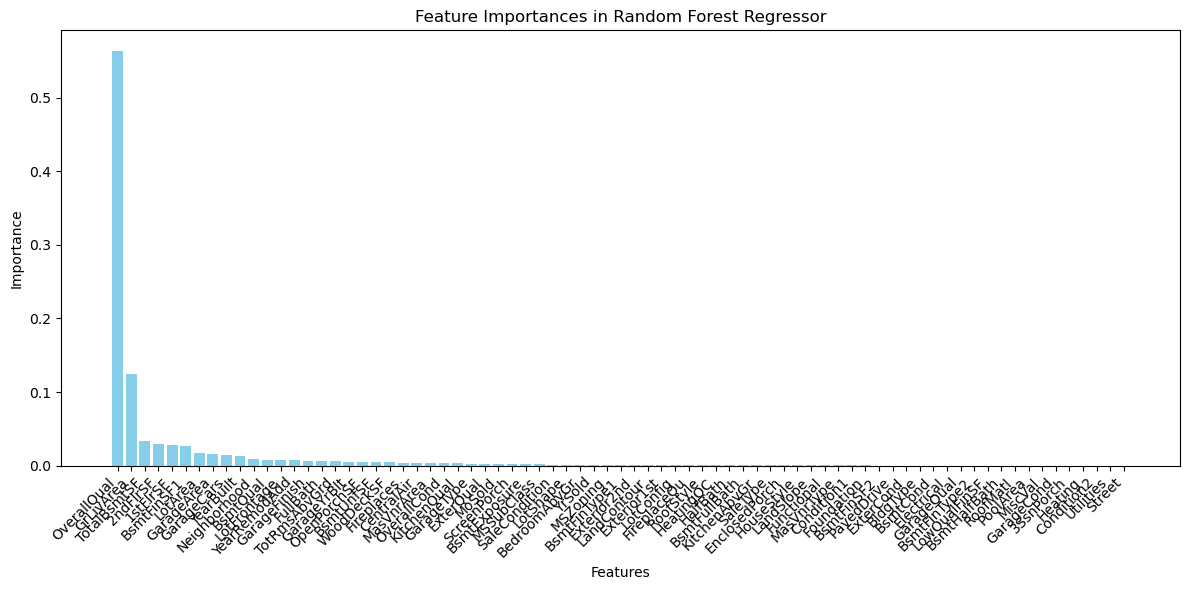

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [46]:
# 特徵重要性分析
feature_importances = model.feature_importances_
feature_names = X.columns

# 將特徵按照重要性排序
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# 繪製特徵重要性條形圖
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features, color="skyblue")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances in Random Forest Regressor")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 篩選重要特徵（前 15 個）
top_n = 15
important_features = [feature_names[i] for i in sorted_indices[:top_n]]
important_importances = sorted_importances[:top_n]
X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]

# 使用篩選後的特徵重新訓練模型
model_imp = RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=2)
model_imp.fit(X_train_imp, y_train_15)
y_pred_rf = model_imp.predict(X_test_imp)

# 評估模型
mae_imp_rf = mean_absolute_error(y_test_15, y_pred_rf)
print(f"MAE using top {top_n} important features: {mae_imp_rf}")

# 顯示房價範圍
print(f"房價範圍：最小值 = {y_test_15.min()}, 最大值 = {y_test_15.max()}")

In [ ]:
# 前15個最重要特徵分別的重要性
print(f"Top {top_n} Important Features and their Importance:")
for feature, importance in zip(important_features, important_importances):
    print(f"{feature}: {importance:.4f}")

print()
# 總重要性
total_importance = sum(important_importances)
print(f"Total Importance: {total_importance:.4f}")

In [ ]:
# 繪製預測值與真實值的散點圖
plt.scatter(y_test_15, y_pred_rf, alpha=0.7)
plt.plot([y_test_15.min(), y_test_15.max()], [y_test_15.min(), y_test_15.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Random Forest)")
plt.show()

#### CNN

In [ ]:
# 使用篩選後的特徵訓練 CNN 模型
model_imp_cnn = build_cnn(input_shape=(len(important_features),1))
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_imp_cnn.fit(X_train_imp, y_train_15, epochs=25, batch_size=8, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# 評估模型
y_pred_imp_cnn = model_imp_cnn.predict(X_test_imp)
mae_imp_cnn = mean_absolute_error(y_test_15, y_pred_imp_cnn)
print(f"MAE with top {top_n} important features(imp cnn): {mae_imp_cnn}")

In [ ]:
# 評估模型
mae_imp_cnn = mean_absolute_error(y_test_15, y_pred_imp_cnn)
print(f"MAE using top {top_n} important features(CNN): {mae_imp_cnn}")

In [ ]:
# 繪製預測值與真實值的散點圖
plt.scatter(y_test_15, y_pred_imp_cnn, alpha=0.7)
plt.plot([y_test_15.min(), y_test_15.max()], [y_test_15.min(), y_test_15.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Top15 CNN)")
plt.show()

#### LSTM

In [ ]:
# 使用篩選後的特徵訓練 lSTM模型
model_imp_lstm = build_lstm(input_shape=(len(important_features),1))
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
model_imp_lstm.fit(X_train_imp, y_train_15, epochs=20, batch_size=8, validation_split=0.2, verbose=1, 
               callbacks=[early_stopping])

# 評估模型
y_pred_imp_lstm = model_imp_lstm.predict(X_test_imp)
mae_imp_lstm = mean_absolute_error(y_test_15, y_pred_imp_lstm)
print(f"MAE with top {top_n} important features(imp lstm): {mae_imp_lstm}")

In [ ]:
# 評估模型
mae_imp_lstm = mean_absolute_error(y_test_15, y_pred_imp_lstm)
print(f"MAE using top {top_n} important features(Top15 LSTM): {mae_imp_lstm}")

In [ ]:
# 繪製預測值與真實值的散點圖
plt.scatter(y_test_15, y_pred_imp_lstm, alpha=0.7)
plt.plot([y_test_15.min(), y_test_15.max()], [y_test_15.min(), y_test_15.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values (Top15 LSTM)")
plt.show()

#### Adaboost

In [ ]:
#important features
top_features = [
    "OverallQual", "GrLivArea", "2ndFlrSF", "1stFlrSF", "TotalBsmtSF",
    "GarageCars", "BsmtFinSF1", "FullBath", "BsmtQual", "GarageArea",
    "YearBuilt", "GarageFinish", "TotRmsAbvGrd", "LotArea", "PoolArea"
]
x_15 = x[top_features]
print(x)

In [ ]:
# 設置模型
max_depth = 10
n_estimators=500
#learning_rate = 0.0001
learning_rate=[0.1,0.01,0.001,0.0001,0.00001]
for i in learning_rate:
  #變數
    learning_rate=i
    base_model = DecisionTreeRegressor(max_depth=max_depth)
    adaboost_reg = AdaBoostRegressor(estimator=base_model, n_estimators=n_estimators, random_state=42 ,learning_rate=learning_rate)
    #adaboost_reg = AdaBoostRegressor(random_state=42,n_estimators=n_estimators,learning_rate=learning_rate)
    adaboost_reg.fit(X_train_15,y_train_15)
# 預測
y_pred_ada = adaboost_reg.predict(X_test_15)

# 使用 MAE 評估模型
mae_ada = mean_absolute_error(y_test_15, y_pred_ada)
print(f"Mean Absolute Error (MAE): {mae_ada:.2f}")
# 繪製預測值與真實值的散點圖
plt.scatter(y_test_15, y_pred_ada, alpha=0.7)
plt.plot([y_test_15.min(), y_test_15.max()], [y_test_15.min(), y_test_15.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs Predicted Values (AdaBoost){mae_ada}")
plt.show()


In [ ]:
# 提取特徵重要性
feature_importances = adaboost_reg.feature_importances_
feature_names = x.columns.tolist()  # 獲取所有剩餘的列名
# 將特徵按照重要性排序
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# 只顯示前15個特徵
top_n = 15
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_features)), top_importances, tick_label=top_features, color="skyblue")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances in AdaBoost Regressor")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(top_features)

## 相關性correlations

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
categorical_cols = x.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col])
    label_encoders[col] = le  # 保存編碼器以備將來解碼

In [ ]:
#相關性

# 確保目標變數也是數值型（如果是類別型，可以轉換或跳過）
if not np.issubdtype(y.dtype, np.number):
    y = y.astype(float)

# 計算數據相關性
correlations = x.corrwith(y)

# 將相關性排序並顯示
correlations_sorted = correlations.sort_values(ascending=False)
print("Feature Correlations with SalePrice:")
print(correlations_sorted)

# 繪製條形圖顯示相關性

plt.figure(figsize=(10, 6))
correlations_sorted.plot(kind='bar', color='skyblue')
plt.title("Feature Correlation with SalePrice")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("feature_correlations_with_saleprice.png", dpi=300)
plt.show()

In [ ]:
# 找出相關性大於 0 的特徵名稱
strong_correlation_features = correlations_sorted[correlations_sorted.abs() > 0.5].index

# 根據相關性篩選出正相關的特徵
x_correlated = x[strong_correlation_features]

# 查看結果
print("Shape of x_correlated:", x_correlated.shape)
print(x_correlated.head())

In [ ]:
# 設置模型
X_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_correlated, y, test_size=0.2, random_state=42)

max_depth = 10
n_estimators=500
#learning_rate = 0.0001
learning_rate=[0.1,0.01,0.001,0.0001,0.00001]
for i in learning_rate:
  #變數
  learning_rate=i


  base_model = DecisionTreeRegressor(max_depth=max_depth)
  adaboost_reg = AdaBoostRegressor(estimator=base_model, n_estimators=n_estimators, random_state=42 ,learning_rate=learning_rate)
  #adaboost_reg = AdaBoostRegressor(random_state=42,n_estimators=n_estimators,learning_rate=learning_rate)

  adaboost_reg.fit(X_train_c,y_train_c)

  # 預測
  y_pred_c = adaboost_reg.predict(x_test_c)

  # 使用 MAE 評估模型

  mae_c = mean_absolute_error(y_test_c, y_pred_c)
  print(f"Mean Absolute Error (MAE): {mae_c:.2f}")


  # 繪製預測值與真實值的散點圖
  plt.scatter(y_test_c, y_pred_c, alpha=0.7)
  plt.plot([y_test_c.min(), y_test_c.max()], [y_test_c.min(), y_test_c.max()], '--r', linewidth=2)
  plt.xlabel("True Values")
  plt.ylabel("Predicted Values")
  plt.title(f"True vs Predicted Values (AdaBoost){mae_c}")


  plt.show()